In [1]:
%matplotlib inline
import math
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat 
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from scipy import io
import scipy

import pyriemann
from pyriemann.classification import KNearestNeighbor

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/P01'
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
tmp = eeg.get_data()


In [3]:
########################################
## Fonctions pour manipuler le signal:##
########################################

def reshape(signal): #transforme le signal total en elevant la dimension d'epoch
    (a,b,c)=signal.shape
    output=np.zeros((b,a*c))
    for i in range (a):
        for j in range (b):
            output[j,i*500:(i+1)*500]=signal[i,j,:]
    return (output)



def signal_freq_filtre(signal,freqs,fenetre): #renvoi les 62 canaux eeg filtrés dans une bande de frequence
    tf=np.fft.fft(signal)

    n = signal.size
    timestep = 1/250
    freq = np.fft.fftfreq(n, d=timestep)

    if freqs=='delta':
        waves=[0.5, 4.5]
    elif freqs=='beta':
        waves=[12 ,35.5]
    elif freqs=='theta':
        waves=[4, 8.5]
    elif freqs=='alpha':
        waves=[8, 12.5]
    elif freqs=='gamma':
        waves=[35, 1000]
    output=np.zeros(len(tf))
    for i in range (len(tf)):
        if i/2 > waves[1] or i/2<=waves[0]:
            tf[i]=0
    output=tf
    return(np.real(np.fft.ifft(output)))

def signalCourt(signal,ind, size): #renvoi une fenetre du signal de taille "size"
    return signal[:,ind:ind+size]


def analytic_signal(x):
    from scipy.fftpack import fft,ifft
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def phase_analytique(x): #signal analytique en input, renvoi la phase du signal
    phi=np.arctan(x.imag/x.real)
    return phi

def amplitude_analytique(x): #signal analytique en input, renvoi l'enveloppe du signal
    return abs(x)

####################################
## Fonction de calcul de matrices:##
####################################


def correlation_threshold(signal,fenetre, indice,frequence, k): #output la matrice binaire par correlation des signaux
#     corr= np.corrcoef(signal_freq_filtre(signal[:,indice:indice+fenetre],frequence, fenetre))
    corr= np.corrcoef(signal[:,indice:indice+fenetre])
    (a,b)=corr.shape
    threshold=np.zeros((a,b))
    return corr

#     for i in range (a):
#         for j in range (b):
#             if corr[i,j]>k:
#                 threshold[i,j]=1
#     return threshold

def covariance_threshold(signal,fenetre, indice,frequence, k):#output la matrice binaire par covariance des signaux
    cov= np.cov(signal_freq_filtre(signal[:,indice:indice+fenetre], frequence, fenetre))
#     cov= np.cov(signal[:,indice:indice+fenetre])
    (a,b)=cov.shape
    threshold=np.zeros((a,b))
    
    return cov

#     for i in range (a):
#         for j in range (b):
#             if cov[i,j]>k:
#                 threshold[i,j]=1
#     return threshold

def matPLV(signal, fenetre, indice, freq): #output: la matrice de phase locking values
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
            dph=ph1-ph2

            PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
            A[i,j]=PLV
    return (A)

def matPLI(signal, fenetre, indice, freq): #output: la matrice de phase lag index
    B=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
        
            dph=ph1-ph2

            PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
            B[i,j]=PLI
    return (B)

def matInfoMut(signal, indice, fenetre,bins):# output: la matrice d'information mutuelle
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            

            X_norm=signalCourt(signal,indice,fenetre)[i]
            Y_norm=signalCourt(signal,indice,fenetre)[j]
            c_xy = np.histogram2d(X_norm, Y_norm, bins)[0]
            mi= mutual_info_score(None, None, contingency=c_xy)
            A[i,j]=mi
            
    return (A)

alphaTable=np.array([[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
                    [0,0,2,3,5,8,10,13,17,21,25,29,34,40,46,52,58,65,73,81,89,98,107,116,126,137]])

def monoExp(x, m, t, b, c):
    return m * np.exp(t * x+c) + b

p0 = (1, 1, 1, 1) # valeurs initiales pour l'optimisation sequentielle
params, cv = scipy.optimize.curve_fit(monoExp, alphaTable[0][:], alphaTable[1][:], p0)
m, t, b, c = params
xs2 = np.arange(50)
ys2 = monoExp(xs2, m, t, b, c)


def matwPLWT(signal, ind, fenetre, freq): ##output: matrice PLWT de poids

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                PLWT=abs((tpos-tneg)/(tpos+tneg))
                A[i,j]=PLWT
    return (A)

def matPLWT(signal, ind, fenetre, freq,alpha=.05): #output:matrice PLWT binaire (utilisant l'approximation gaussienne pour n>30)

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                T=min(tpos, tneg)
                n=len(theta1)
                if (n<=30) :
                    Tc=alphaTable[1][n-5]
                    if T<Tc:
                        PLWT=1
                    else:
                        PLWT=0
                else:
                    sig=(n*(n+1)*(2*n+1)/24)
                    mu=n*(n+1)/4
                    Z=(T-mu)/(sig)
                    Zc=1.645 # basé sur gaussienne centrée réduite (ne marche pas)
                    if Z<Zc:
                        PLWT=1
                    else:
                        PLWT=0
                A[i,j]=PLWT
    return (A)


##########################################
## Fonction pour manipuler les matrices:##
##########################################

def emptyDiago(A): #output la matrice mais avec une diagonale vide
    for i in range (A.shape[0]):
        A[i,i]=0
    return (A)

def degreeMat(A): #output: matrice de degrée (termes des lignes sommées sur la diagonale)
    a,b=A.shape
    B=np.zeros((a,b))
    for i in range (a):
        s=0
        for j in range (b):
            s=s+A[i,j]
        B[i,i]=s
    return (B)

def laplacien(A): #renvoi la matrice ayant subit le laplacien
    return (degreeMat(emptyDiago(A))-emptyDiago(A))

def threshold(mat,k): #renvoi la matrice binaire si le threshold est dépassé ou non
    return np.where(mat>k, 1,0)

def vectorise(mat): #extrait la partie triangulaire supérieur de la matrice sous forme de vecteur unidimensionel
    return mat[np.triu_indices(mat.shape[0],k=1)]

def shuffle_in_unison(a, b): #mélange a et b de la meme manière
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


In [5]:
# Cette fonction créer un vecteur de taille ((n*N)*K) où n*N est le nombre d'instances où l'on calcule une statistique
# à travers les 6 sessions du sujet 1 (n:instants/session (= instants/fichier) et N: nombre de sessions)
# K est la taille du vecteur qui provient de la matrice 61x61 --> K=(60*61)/2
# Output: Y qui est le vecteur qui contient 0,1 ou 2 en fonction de la difficulté de charge mentale
#      et X qui est le vecteur ((n*N)*K) des données calculéers selon 'mesure'



def makeTrain(N,n,taillef,frequence,mesure,thresh, bins=5 ): #n est le nombre d'instants par session, N est le nombre de sessions
    data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet'
    numberVect=np.array(['1','1','1','2','2','2']) #le numéro de session du patient 01 (en tout 6 fichiers car 2 sessions de 3 mesures sont labelisées)
    M=numberVect.shape[0]
    diffVect=np.array(['diff', 'easy', 'med', 'diff','easy', 'med']) #les difficultés associées au fichiers .set
    y=np.zeros((N*n,1))
    x=np.zeros((N*n,1830))
    
    for k in range(M):
        array='/patient1/alldata_sbj01_sess'+numberVect[k]+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec toutes les sessions d'un meme sujet réuni
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=(10**6)*reshape(tmp)     
        for i in range (n):
            indice=int((signalTotal2.shape[1]-taillef)*i/n) #réparti uniformément l'indice sur les 5 mins de mesure
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            elif mesure=="correlation":
#                 mat=threshold(correlation_threshold(signalTotal2,taillef, indice,frequence,thresh),thresh)
                mat=correlation_threshold(signalTotal2,taillef, indice,frequence,thresh)
            elif mesure=="covariance":
#                 mat=threshold(covariance_threshold(signalTotal2,taillef, indice, frequence, thresh), thresh)
                mat=covariance_threshold(signalTotal2,taillef, indice, frequence, thresh)
                
            x[n*k+i,:]=vectorise(mat).T #rempli par ligne la matrice x
            

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2              ## associe la difficulté au vecteur y
                
                
#         print(k)
    return (x,y)



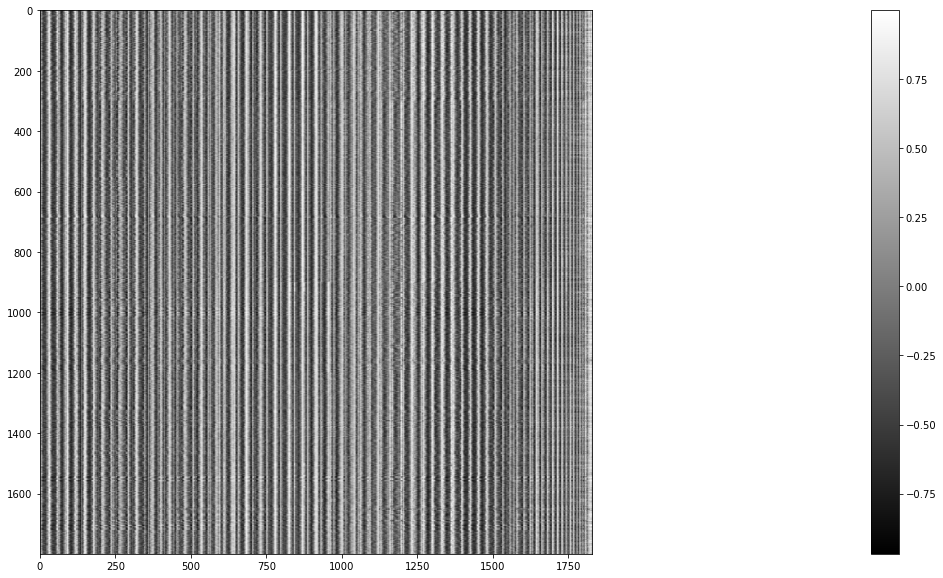

In [9]:
N1=6
n1=300

(X1,Y1)=makeTrain(N1,n1,500,'alpha','correlation',200,5)
plt.figure(figsize=(100,10))
plt.imshow(X1,aspect=1,cmap='gray')
plt.colorbar()




xnew (1800, 1830)
ynew (1800, 1)


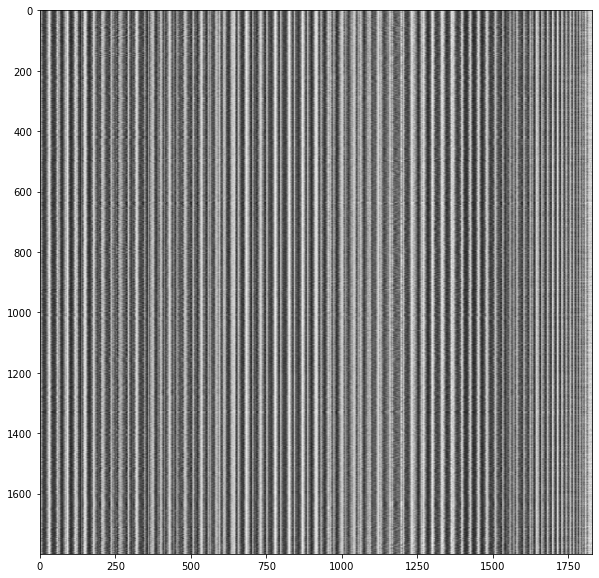

In [11]:
(Xnew,Ynew)=shuffle_in_unison(X1,Y1)
plt.figure(figsize=(100,10))
plt.imshow(Xnew,aspect=1,cmap='gray')
print("xnew" ,Xnew.shape)
print("ynew" ,Ynew.shape)

#On mélange les données 

In [12]:
index=int(0.8*N1*n1)
print(index)

Xtrain=Xnew[0:index]
Xtest=Xnew[index:N1*n1]
Ytrain=Ynew[0:index]
Ytest=Ynew[index:N1*n1]   ##on sépare les données train et test

Ytrain=Ytrain.ravel()
Ytest=Ytest.ravel()

neigh = KNeighborsClassifier(n_neighbors=2) #classification KNN classique
neigh.fit(Xtrain, Ytrain)

sco1=neigh.score(Xtest, Ytest)
print(sco1, "sco1")


clf = svm.SVC(kernel="rbf", gamma=0.01) #classification SVM marche le mieu pour kernel rbf et gamma=0.01, pour covariance et 300 instants
clf.fit(Xtrain, Ytrain)
sco2=clf.score(Xtest,Ytest)
print(sco2, "sco2")


1440
0.7583333333333333 sco1
0.8638888888888889 sco2


In [222]:
# de bon scores pour la correlation

601.7402522990382


In [13]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=10000).fit(Xtrain, Ytrain) # classification réseau de neurone
sco3=clf.score(Xtest, Ytest)
print(sco3)


0.8638888888888889


In [ ]:
## Commentaires généraux de test ##

# de bons scores pour la correlation no threshold, de meme pour la covariance non threshold
# Probleme technique pour le thresholding de la covariance et de la correlation
# Utiliser un bon threshold peut beaucoup augmenter les résultats de scores (pour la correlation en tout cas ~85%)

# Il semblerait que les résultats sont en effet meilleurs avec du thresholding, mais il faut
# trouver le bon threshold correspondant à chaque bande de fréquence


In [20]:
# cette fonction renvoi une matrice (N*n)*(K*6) contenant l'information statistique calculées su les 6 bandes de fréquence
#N: nombres de sessions (ou de fichiers.set)
#n: nombre d'instants par sessions
#K: 60*61/2
#6: nombre de différentes bandes de fréquences


def makeTrainFreq(N,n,taillef,mesure,bins=5 ): 
    freqs=np.array(['delta','beta', 'theta', 'alpha' ,'gamma'])
#     thresholds=np.array([200,200,200,200,200])
    thresholds=np.array([0.1,0.1,0.1,0.1,0.1])
    F=freqs.shape[0]
    K=1830
    x=np.zeros((N*n,K*F))
    
    for f in range(F):
        (Xtemp,Ytemp)=makeTrain(N,n,taillef,str(freqs[f]),mesure,thresholds[f],bins)
        x[:,f*K:(f+1)*K]=Xtemp
    return(x,Ytemp)

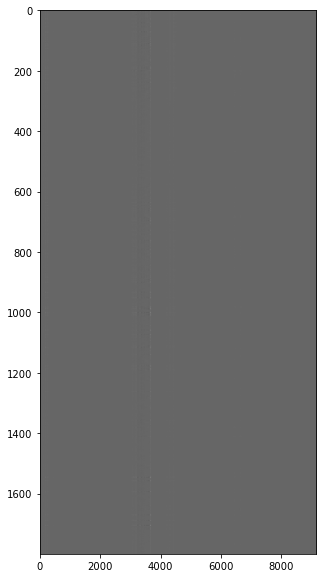

In [21]:
N1=6
n1=300

(X1,Y1)=makeTrainFreq(N1,n1,500,'covariance',5) #pour la mesure correlation threshold: ne marche pas ?
plt.figure(figsize=(100,10))
plt.imshow(X1,aspect=10,cmap='gray')


In [19]:
(Xnew,Ynew)=shuffle_in_unison(X1,Y1)

index=int(0.8*N1*n1)
print(index)

Xtrain=Xnew[0:index]
Xtest=Xnew[index:N1*n1]
Ytrain=Ynew[0:index]
Ytest=Ynew[index:N1*n1]   ##on sépare les données train et test

Ytrain=Ytrain.ravel()
Ytest=Ytest.ravel()

neigh = KNeighborsClassifier(n_neighbors=2) #classification KNN classique
neigh.fit(Xtrain, Ytrain)

sco1=neigh.score(Xtest, Ytest)
print(sco1, "sco1")


clf = svm.SVC(kernel="rbf", gamma=0.01) #classification SVM marche le mieu pour kernel rbf et gamma=0.01, pour covariance et 300 instants
clf.fit(Xtrain, Ytrain)
sco2=clf.score(Xtest,Ytest)
print(sco2, "sco2")



1440
0.6388888888888888 sco1
0.3055555555555556 sco2


In [ ]:
# remarque: pour un meme nombre total d'instants (6*300), les résultats de classification sont moins bien si on 
# prend en comptes les 6 bandes de fréquences 